In [1]:
import io
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

In [18]:
DIM = 300
POINTS = 20000

matrix = np.zeros((POINTS,DIM))
for i in range(POINTS):
    v = np.random.randn(DIM)
    matrix[i] = v

query = np.random.randn(DIM)
query = query.reshape((1, DIM))

dists = cosine_similarity(matrix, query)

In [19]:
dists

array([[-0.15334445],
       [ 0.00767121],
       [-0.03787881],
       ...,
       [ 0.04340839],
       [ 0.00355914],
       [-0.00552335]])

In [2]:
embd = load_vectors('data/glove/glove.840B.300d.txt')

In [16]:
embd['<CLS>']

KeyError: '<CLS>'

In [315]:
embd_matrix = list(embd.values())[1:]

In [316]:
embd_matrix = np.array(embd_matrix)
# embd_matrix /= np.linalg.norm(embd_matrix, axis=1, ord=2).reshape((-1,1))

In [317]:
embd_matrix.shape

(2196015, 300)

In [318]:
embd_keys = list(embd.keys())[1:]

In [384]:
def noisy_nnb(word_list, embd, embd_keys, embd_matrix, eps=1.0, seed=None, nth=2):
    # Setting the seed
    if seed is not None:
        np.random.seed(seed)
    
    # eps = 0 provides absolute privacy
    length = len(word_list)
    query = []
    for word in word_list:
        try:
            query.append(embd[word])
        except:
            query.append(np.zeros(300))
        
    query = np.array(query).reshape(length, -1)
#     query = query / np.linalg.norm(query, axis=1, ord=2).reshape((-1,1))
    
    # Add noise
#    noise = np.random.exponential(scale=1.0/(eps+1e-6), size=query.shape) * (2 * np.random.binomial(n=1, p=0.5, size=query.shape) - 1) * 0.1
    normal_noise = np.random.normal(size=query.shape)
    normal_noise /= np.linalg.norm(normal_noise, axis=1).reshape((-1, 1))
    noise = normal_noise * np.random.gamma(eps, size=(len(query), 1))
#     noise = normal_noise * eps
    query = query + noise
    
    dist = cosine_similarity(embd_matrix, query)
#     dist = euclidean_distances(embd_matrix, query)
    
    return dist, [embd_keys[i] for i in dist.argsort(axis=0)[-nth]], noise

In [385]:
dists, words, noise = noisy_nnb(['abhinav', 'alex', 'christopher', 'john', 'david', 'alexander', 'tyler', 'anjishnu', 'flight'], embd, embd_keys, embd_matrix, eps=1, seed=100, nth=10)
words

['shashi',
 'danny',
 'charles',
 'william',
 'andrew',
 'oliver',
 'davis',
 'DescriptionPosition',
 'fly']

In [387]:
dists, words, noise = noisy_nnb(['the', 'flight', 'time', 'and'], embd, embd_keys, embd_matrix, eps=5, seed=1000, nth=5)
words

['entire', 'airplane', 'until', 'etc.']

In [365]:
'the flight time between south korea and singapore'.split(' ')

['the', 'flight', 'time', 'between', 'south', 'korea', 'and', 'singapore']

In [388]:
dists, words, noise = noisy_nnb(list('the flight time between south korea and singapore'.split(' ')), embd, embd_keys, embd_matrix, eps=1, seed=100, nth=5)
words

['The',
 'airplane',
 'before',
 'across',
 'southeast',
 'asia',
 'while',
 'thailand']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-3.51794342, -3.37465077, -3.23135813, -3.08806548, -2.94477284,
        -2.80148019, -2.65818755, -2.5148949 , -2.37160225, -2.22830961,
        -2.08501696, -1.94172432, -1.79843167, -1.65513903, -1.51184638,
        -1.36855374, -1.22526109, -1.08196845, -0.9386758 , -0.79538315,
        -0.65209051, -0.50879786, -0.36550522, -0.22221257, -0.07891993,
         0.06437272,  0.20766536,  0.35095801,  0.49425066,  0.6375433 ,
         0.78083595,  0.92412859,  1.06742124,  1.21071388,  1.35400653,
         1.49729917,  1.64059182,  1.78388446,  1.92717711,  2.07046976,
         2.2137624 ,  2.35705505,  2.50034769,  2.64364034,  2.78693298,
         2.93022563,  3.07351827,  3.21681092,  3.36010357,  3.50339621,
         3.64668886])

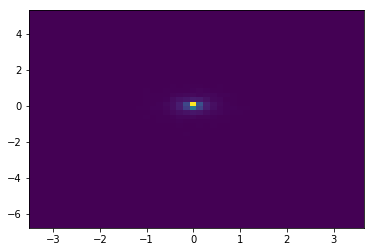

In [348]:
normal_noise = np.random.normal(size=(10000,10))
normal_noise /= np.linalg.norm(normal_noise, axis=1, ord=2).reshape((-1, 1))
noise = normal_noise * np.random.gamma(1, size=(10000, 1))
plt.hist2d(noise[:,0], noise[:,1], bins=(50,50))

In [213]:
noise = np.random.normal(size=query.shape) * np.random.gamma(1, size=(len(query), 1))

In [218]:
np.random.gamma(1, size=(len(query), 1))

array([[0.43118377]])

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [24]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([0,1,0,1,1,1], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[-2.5667, -1.4303,  0.5009,  0.5438, -0.4057],
        [ 1.1341, -1.1115,  0.3501, -0.7703, -0.1473],
        [-2.5667, -1.4303,  0.5009,  0.5438, -0.4057],
        [ 1.1341, -1.1115,  0.3501, -0.7703, -0.1473],
        [ 1.1341, -1.1115,  0.3501, -0.7703, -0.1473],
        [ 1.1341, -1.1115,  0.3501, -0.7703, -0.1473]],
       grad_fn=<EmbeddingBackward>)


In [43]:
for i in embeds.parameters():
    print(i)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.1341, -1.1115,  0.3501, -0.7703, -0.1473]], grad_fn=<CopySlices>)


In [58]:
from torch.autograd import Variable
a = Variable(torch.randn(3,2), requires_grad=True)
a

tensor([[ 0.6984, -0.8005],
        [ 1.5381,  1.4673],
        [ 1.5951, -1.5279]], requires_grad=True)

False

In [59]:
b = torch.randn(3,2,5)

In [61]:
b[0,0,].size()

torch.Size([5])

In [63]:
a = torch.randn(2,3,4)
b = torch.randn(1,4,3)
torch.matmul(a, b).size()

torch.Size([2, 3, 3])

In [66]:
a.repeat(1,2,1).size()

torch.Size([2, 6, 4])

In [71]:
a = torch.randn(1, 3, 2) # [B, T, D]
a

tensor([[[ 0.8803,  0.5456],
         [-0.5979,  0.3257],
         [-0.5642, -1.1759]]])

In [77]:
a = a.repeat(1, 1, 3).view(1, 3, 3, 2) # [B, T, T, D]
a

tensor([[[[ 0.8803,  0.5456],
          [ 0.8803,  0.5456],
          [ 0.8803,  0.5456]],

         [[-0.5979,  0.3257],
          [-0.5979,  0.3257],
          [-0.5979,  0.3257]],

         [[-0.5642, -1.1759],
          [-0.5642, -1.1759],
          [-0.5642, -1.1759]]]])

In [87]:
h = torch.randn(1, 3, 4, 2) # [B, T, T2, D]
h

tensor([[[[ 1.5083,  0.1054],
          [-1.6050, -0.1064],
          [ 0.2466,  0.6125],
          [-0.0077,  2.6158]],

         [[ 1.0757, -0.5536],
          [-1.6160,  0.0934],
          [-1.3898, -0.3105],
          [ 1.0693,  1.4394]],

         [[ 1.3694,  0.4539],
          [-0.0498,  0.3745],
          [ 1.4389,  1.4151],
          [-0.1589, -0.7360]]]])

In [88]:
result = torch.diagonal( a.matmul(h.transpose(-2, -1)), dim1=1, dim2=2 ).transpose(-2, -1)
result

tensor([[[ 1.3853, -1.4709,  0.5513,  1.4205],
         [-0.8234,  0.9966,  0.7298, -0.1705],
         [-1.3064, -0.4123, -2.4758,  0.9552]]])

In [86]:
result.size() # [B, T, T2]

torch.Size([1, 3, 4])

In [89]:
D = torch.randn(2, 5, 5)
torch.diagonal(D, dim1=1, dim2=2).size()

torch.Size([2, 5])

In [93]:
dd = torch.randn(2,1,3,4)

In [94]:
dd

tensor([[[[-0.3499, -0.2344, -0.5452,  0.2751],
          [-1.1834, -0.8202,  0.3057,  0.1398],
          [-0.8873,  0.5298,  0.2684,  0.3501]]],


        [[[-0.2723,  1.0666, -0.8953,  1.4148],
          [-0.9173,  0.8372,  1.4950, -0.8303],
          [-1.9901, -0.8779,  0.2204, -1.9548]]]])

In [95]:
torch.argmax(dd, dim=-1).size()

torch.Size([2, 1, 3])